# Textual-inversion fine-tuning for Stable Diffusion using d🧨ffusers

This notebook shows how to "teach" Stable Diffusion a new concept via textual-inversion using 🤗 Hugging Face [🧨 Diffusers library](https://github.com/huggingface/diffusers).
The base of the script is provided by Hugging Face and can be found at: https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/sd_textual_inversion_training.ipynb


## Initial setup

In [1]:
# ========== Reporte ==========
from datetime import datetime
import time
process_start = datetime.now()
time_start = time.time()
report = (
    f"Reporte Fine tunning Stable Diffusion mediante Textual Inversion\n"
    f"----------------------------------------------------------------\n"
    f"Inicio del proceso: {process_start} \n"
)

In [2]:
# Montar Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
conf_start_time = time.time()
report += f": {datetime.now()} -- Comienza la configuración del entorno de ejecución\n"

requirements_path = "/content/drive/MyDrive/UNIR/TFM/TI/requirements.txt"
!pip install -r "{requirements_path}"

report += f"Configuración completada. Tiempo empleado en establecer la configuración inicial: {time.time() - conf_start_time} segundos.\n"
report += f"----------------------------------------------------------------\n"

  Cloning https://github.com/huggingface/diffusers.git (to revision 73a9d5856f2d7ae3637c484d83cd697284ad3962) to /tmp/pip-install-5rtgbyqh/diffusers_c1175fa1059d487d90ce47d34b4399a6
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/diffusers.git /tmp/pip-install-5rtgbyqh/diffusers_c1175fa1059d487d90ce47d34b4399a6
  Running command git rev-parse -q --verify 'sha^73a9d5856f2d7ae3637c484d83cd697284ad3962'
  Running command git fetch -q https://github.com/huggingface/diffusers.git 73a9d5856f2d7ae3637c484d83cd697284ad3962
  Running command git checkout -q 73a9d5856f2d7ae3637c484d83cd697284ad3962
  Resolved https://github.com/huggingface/diffusers.git to commit 73a9d5856f2d7ae3637c484d83cd697284ad3962
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.2/779.2 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [4]:
#@title Import required libraries
import argparse
import itertools
import math
import os
import random

import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
from torch.utils.data import Dataset

import PIL
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import set_seed
from diffusers import AutoencoderKL, DDPMScheduler, PNDMScheduler, StableDiffusionPipeline, UNet2DConditionModel
from diffusers.optimization import get_scheduler
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer

import time
import itertools
import accelerate
import subprocess

In [5]:
from PIL import Image
import glob

## Settings for teaching your new concept

In [6]:
load_start_time = time.time()
report += f": {datetime.now()} -- Comienza la configuración relativa al nuevo concepto a entrenar\n"

In [7]:
#@markdown `pretrained_model_name_or_path` which Stable Diffusion checkpoint you want to use
pretrained_model_name_or_path = "runwayml/stable-diffusion-v1-5" #@param ["stabilityai/stable-diffusion-2", "stabilityai/stable-diffusion-2-base", "CompVis/stable-diffusion-v1-4", "runwayml/stable-diffusion-v1-5"] {allow-input: true}

### Get the training images:

In [8]:
# En caso de no tener la imagenes ya en colab o en drive, se traen las imagenes (y captions) de github
import os
from pathlib import Path

# Ruta local donde guardarás los datos
data_root = Path("/content/data/concept_data")
data_root.mkdir(parents=True, exist_ok=True)

# Lista de imágenes y captions que quieres usar
files = ["zapatilla_20.JPEG", "zapatilla_20.txt",
         "zapatilla_26.JPEG", "zapatilla_26.txt",
         "zapatilla_31.jpg", "zapatilla_31.txt",
         "zapatilla_32.jpg", "zapatilla_32.txt",
         "zapatilla_36.jpg", "zapatilla_36.txt"
         ]

# Descargar desde GitHub
base_url = "https://github.com/sgonzalezgg/sd-finetuning-comparison/raw/main/data/concept_data/"
for file in files:
    url = base_url + file
    os.system(f"wget -q {url} -P {data_root}")

images_path = data_root
save_path = images_path

In [9]:
# #@title Leer imágenes desde Drive
# #@markdown `images_path` is a path to directory containing the training images. It could
# images_path = "/content/drive/MyDrive/UNIR/TFM/zapatillas/" #@param {type:"string"}
# while not os.path.exists(str(images_path)):
#   print('The images_path specified does not exist, use the colab file explorer to copy the path :')
#   images_path=input("")
# save_path = images_path

####  Setup and check the images you have just added

In [10]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [11]:
images = []
valid_exts = [".jpg", ".jpeg", ".png", ".bmp", ".gif"]
for file_path in os.listdir(save_path):
  if not any(file_path.lower().endswith(ext) for ext in valid_exts):
    print(f"Saltando archivo no imagen: {file_path}")
    continue
  try:
      image_path = os.path.join(save_path, file_path)
      images.append(Image.open(image_path).resize((512, 512)))
  except:
    print(f"{image_path} is not a valid image, please make sure to remove this file from the directory otherwise the training could fail.")

image_grid(images, 1, len(images))

Output hidden; open in https://colab.research.google.com to view.

In [12]:
#@title Settings for your newly created concept
#@markdown `what_to_teach`: what is it that you are teaching? `object` enables you to teach the model a new object to be used, `style` allows you to teach the model a new style one can use.
what_to_teach = "object" #@param ["object", "style"]
#@markdown `placeholder_token` is the token you are going to use to represent your new concept (so when you prompt the model, you will say "A `<my-placeholder-token>` in an amusement park"). We use angle brackets to differentiate a token from other words/tokens, to avoid collision.
placeholder_token = "<zptx>" #@param {type:"string"}
#@markdown `initializer_token` is a word that can summarise what your new concept is, to be used as a starting point
initializer_token = "sneaker" #@param {type:"string"}

## Teach the model a new concept (fine-tuning with textual inversion)
Execute this this sequence of cells to run the training process. The whole process may take from 1-4 hours. (Open this block if you are interested in how this process works under the hood or if you want to change advanced training settings or hyperparameters)

### Create Dataset

In [13]:
# # #@title Setup the prompt templates for training
# imagenet_templates_small = [
#     "a photo of a {} sneaker, side view, on a white background",
#     "a studio photo of the {} on a clean surface",
#     "a close-up of a {} sneaker with good lighting",
#     "a product shot of the {} shoe on a plain background",
#     "a centered {} sneaker, profile view, isolated",
#     "the {} sneaker, front view, on white backdrop",
#     "a {} sneaker photographed from above",
#     "a detailed photo of the {} sneaker on a neutral surface",
#     "a high quality image of the {} on a white studio background",
#     "a {} sneaker, slightly rotated, on a flat white surface",
# ]

# # imagenet_style_templates_small = [
# #     "a painting in the style of {}",
# #     "a rendering in the style of {}",
# #     "a cropped painting in the style of {}",
# #     "the painting in the style of {}",
# #     "a clean painting in the style of {}",
# #     "a dirty painting in the style of {}",
# #     "a dark painting in the style of {}",
# #     "a picture in the style of {}",
# #     "a cool painting in the style of {}",
# #     "a close-up painting in the style of {}",
# #     "a bright painting in the style of {}",
# #     "a cropped painting in the style of {}",
# #     "a good painting in the style of {}",
# #     "a close-up painting in the style of {}",
# #     "a rendition in the style of {}",
# #     "a nice painting in the style of {}",
# #     "a small painting in the style of {}",
# #     "a weird painting in the style of {}",
# #     "a large painting in the style of {}",
# # ]

In [14]:
#@title Setup the dataset
from pathlib import Path
class TextualInversionDataset(Dataset):
    def __init__(
        self,
        data_root,
        tokenizer,
        learnable_property="object",  # [object, style]
        size=512,
        repeats=100,
        interpolation="bicubic",
        flip_p=0,
        set="train",
        placeholder_token="*",
        center_crop=False,
    ):

        self.data_root = Path(data_root)
        self.tokenizer = tokenizer
        self.learnable_property = learnable_property
        self.size = size
        self.placeholder_token = placeholder_token
        self.center_crop = center_crop
        self.flip_p = flip_p

        # Filtrar solo imágenes válidas
        # NUEVO
        image_extensions = [".png", ".jpg", ".jpeg", ".bmp", ".webp"]
        self.image_caption_pairs = []

        print(self.data_root)

        for file_path in os.listdir(self.data_root):
            img_path = self.data_root / file_path
            if img_path.suffix.lower() in image_extensions:
                caption_path = img_path.with_suffix(".txt")
                if caption_path.exists():
                    self.image_caption_pairs.append((img_path, caption_path))

        self.num_images = len(self.image_caption_pairs)
        self._length = self.num_images * repeats if set == "train" else self.num_images
        # FIN NUEVO

        self.interpolation = {
            "linear": PIL.Image.BILINEAR, # ya no hay linear
            "bilinear": PIL.Image.BILINEAR,
            "bicubic": PIL.Image.BICUBIC,
            "lanczos": PIL.Image.LANCZOS,
        }[interpolation]

        # self.templates = imagenet_style_templates_small if learnable_property == "style" else imagenet_templates_small
        self.flip_transform = transforms.RandomHorizontalFlip(p=self.flip_p)

    def __len__(self):
        return self._length

    def __getitem__(self, i):
        example = {}

        # NUEVO
        # Index con repetición
        img_path, caption_path = self.image_caption_pairs[i % self.num_images]

        # print(img_path)

        # image = Image.open(self.image_paths[i % self.num_images])
        image = Image.open(img_path)
        if image.mode != "RGB":
            image = image.convert("RGB")

        # FIN NUEVO

        # if not image.mode == "RGB":
        #     image = image.convert("RGB")

        # Leer caption personalizado
        with open(caption_path, "r", encoding="utf-8") as f:
            text = f.read().strip()

        # placeholder_string = self.placeholder_token
        # text = random.choice(self.templates).format(placeholder_string)

        example["input_ids"] = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.tokenizer.model_max_length,
            return_tensors="pt",
        ).input_ids[0]

        # default to score-sde preprocessing
        img = np.array(image).astype(np.uint8)

        if self.center_crop:
            crop = min(img.shape[0], img.shape[1])
            h, w, = (
                img.shape[0],
                img.shape[1],
            )
            img = img[(h - crop) // 2 : (h + crop) // 2, (w - crop) // 2 : (w + crop) // 2]

        image = Image.fromarray(img)
        image = image.resize((self.size, self.size), resample=self.interpolation)

        image = self.flip_transform(image)
        image = np.array(image).astype(np.uint8)
        image = (image / 127.5 - 1.0).astype(np.float32)

        example["pixel_values"] = torch.from_numpy(image).permute(2, 0, 1)
        return example

In [15]:
report += f"Configuración relativa al nuevo concepto a entrenar completada. \n"
report += f"Tiempo empleado: {time.time() - load_start_time} segundos.\n"
report += f"----------------------------------------------------------------\n"

### Setting up the model

In [16]:
model_settings_start_time = time.time()
report += f": {datetime.now()} -- Comienza la configuración del modelo \n"

In [17]:
#@title Load the tokenizer and add the placeholder token as a additional special token.
tokenizer = CLIPTokenizer.from_pretrained(
    pretrained_model_name_or_path,
    subfolder="tokenizer",
)

# Add the placeholder token in tokenizer
num_added_tokens = tokenizer.add_tokens(placeholder_token)
if num_added_tokens == 0:
    raise ValueError(
        f"The tokenizer already contains the token {placeholder_token}. Please pass a different"
        " `placeholder_token` that is not already in the tokenizer."
    )

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

In [18]:
#@title Get token ids for our placeholder and initializer token. This code block will complain if initializer string is not a single token
# Convert the initializer_token, placeholder_token to ids
token_ids = tokenizer.encode(initializer_token, add_special_tokens=False)
# Check if initializer_token is a single token or a sequence of tokens
if len(token_ids) > 1:
    raise ValueError("The initializer token must be a single token.")

initializer_token_id = token_ids[0]
placeholder_token_id = tokenizer.convert_tokens_to_ids(placeholder_token)

In [19]:
#@title Load the Stable Diffusion model
# Load models and create wrapper for stable diffusion
# pipeline = StableDiffusionPipeline.from_pretrained(pretrained_model_name_or_path)
# del pipeline
text_encoder = CLIPTextModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="text_encoder"
)
vae = AutoencoderKL.from_pretrained(
    pretrained_model_name_or_path, subfolder="vae"
)
unet = UNet2DConditionModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="unet"
)

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

We have added the `placeholder_token` in the `tokenizer` so we resize the token embeddings here, this will a new embedding vector in the token embeddings for our `placeholder_token`

In [20]:
text_encoder.resize_token_embeddings(len(tokenizer))

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Embedding(49409, 768)

 Initialise the newly added placeholder token with the embeddings of the initializer token

In [21]:
token_embeds = text_encoder.get_input_embeddings().weight.data
token_embeds[placeholder_token_id] = token_embeds[initializer_token_id]

In Textual-Inversion we only train the newly added embedding vector, so lets freeze rest of the model parameters here

In [22]:
def freeze_params(params):
    for param in params:
        param.requires_grad = False

# Freeze vae and unet
freeze_params(vae.parameters())
freeze_params(unet.parameters())
# Freeze all parameters except for the token embeddings in text encoder
params_to_freeze = itertools.chain(
    text_encoder.text_model.encoder.parameters(),
    text_encoder.text_model.final_layer_norm.parameters(),
    text_encoder.text_model.embeddings.position_embedding.parameters(),
)
freeze_params(params_to_freeze)

In [23]:
report += f"Configuración relativa al modelo completada. \n"
report += f"Tiempo empleado: {time.time() - model_settings_start_time} segundos.\n"
report += f"----------------------------------------------------------------\n"

### Creating our training data

In [24]:
training_data_start_time = time.time()
report += f": {datetime.now()} -- Creación del conjunto de entrenamiento \n"

Let's create the Dataset and Dataloader

In [25]:
train_dataset = TextualInversionDataset(
      data_root=save_path,
      tokenizer=tokenizer,
      size=vae.sample_size,
      placeholder_token=placeholder_token,
      repeats=100,
      learnable_property=what_to_teach, #Option selected above between object and style
      center_crop=False,
      set="train",
)

/content/data/concept_data


<ipython-input-25-3402164851>:4: FutureWarning: Accessing config attribute `sample_size` directly via 'AutoencoderKL' object attribute is deprecated. Please access 'sample_size' over 'AutoencoderKL's config object instead, e.g. 'unet.config.sample_size'.
  size=vae.sample_size,


In [26]:
def create_dataloader(train_batch_size=1):
    return torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)

Create noise_scheduler for training

In [27]:
noise_scheduler = DDPMScheduler.from_config(pretrained_model_name_or_path, subfolder="scheduler")

/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:248: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'diffusers.schedulers.scheduling_ddpm.DDPMScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)


scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

In [28]:
report += f"Creación del tablón de entrenamiento completada. \n"
report += f"Tiempo empleado: {time.time() - training_data_start_time} segundos.\n"
report += f"----------------------------------------------------------------\n"

### Training

In [29]:
training_start_time = time.time()
report += f": {datetime.now()} -- Inicio del entrenamiento \n"

Define hyperparameters for our training
If you are not happy with your results, you can tune the `learning_rate` and the `max_train_steps`

In [30]:
#@title Setting up all training args
hyperparameters = {
    "learning_rate": 5e-4, # 5e-04
    "scale_lr": False,
    "max_train_steps": 1500, # 2000
    "save_steps": 500,
    "train_batch_size": 1, # 4
    "gradient_accumulation_steps": 1,
    "gradient_checkpointing": True,
    "mixed_precision": "fp16",
    "seed": 42,
    "output_dir": "sd-concept-output"
}
!mkdir -p sd-concept-output

Train!

In [31]:
#@title Training function
logger = get_logger(__name__)

def save_progress(text_encoder, placeholder_token_id, accelerator, save_path):
    logger.info("Saving embeddings")
    learned_embeds = accelerator.unwrap_model(text_encoder).get_input_embeddings().weight[placeholder_token_id]
    learned_embeds_dict = {placeholder_token: learned_embeds.detach().cpu()}
    torch.save(learned_embeds_dict, save_path)

def log_memory_usage(step):
    import datetime
    import psutil
    now = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    gpu_mem_used = torch.cuda.memory_allocated() / 1024**2
    gpu_mem_reserved = torch.cuda.memory_reserved() / 1024**2
    ram_used = psutil.virtual_memory().used / 1024**3
    log_line = f"[{now}] Step {step} | GPU Used: {gpu_mem_used:.2f} MB | GPU Reserved: {gpu_mem_reserved:.2f} MB | RAM: {ram_used:.2f} GB"
    print(log_line)
    with open("memory_log.txt", "a") as f:
        f.write(log_line + "\n")

def training_function(text_encoder, vae, unet):
    train_batch_size = hyperparameters["train_batch_size"]
    gradient_accumulation_steps = hyperparameters["gradient_accumulation_steps"]
    learning_rate = hyperparameters["learning_rate"]
    max_train_steps = hyperparameters["max_train_steps"]
    output_dir = hyperparameters["output_dir"]
    gradient_checkpointing = hyperparameters["gradient_checkpointing"]

    accelerator = Accelerator(
        gradient_accumulation_steps=gradient_accumulation_steps,
        mixed_precision=hyperparameters["mixed_precision"]
    )

    if gradient_checkpointing:
        text_encoder.gradient_checkpointing_enable()
        unet.enable_gradient_checkpointing()

    train_dataloader = create_dataloader(train_batch_size)

    if hyperparameters["scale_lr"]:
        learning_rate = (
            learning_rate * gradient_accumulation_steps * train_batch_size * accelerator.num_processes
        )

    # Initialize the optimizer
    optimizer = torch.optim.AdamW(
        text_encoder.get_input_embeddings().parameters(),  # only optimize the embeddings
        lr=learning_rate,
    )

    text_encoder, optimizer, train_dataloader = accelerator.prepare(
        text_encoder, optimizer, train_dataloader
    )

    weight_dtype = torch.float32
    if accelerator.mixed_precision == "fp16":
        weight_dtype = torch.float16
    elif accelerator.mixed_precision == "bf16":
        weight_dtype = torch.bfloat16

    # Move vae and unet to device
    vae.to(accelerator.device, dtype=weight_dtype)
    unet.to(accelerator.device, dtype=weight_dtype)

    # Keep vae in eval mode as we don't train it
    vae.eval()
    # Keep unet in train mode to enable gradient checkpointing
    unet.train()


    # We need to recalculate our total training steps as the size of the training dataloader may have changed.
    num_update_steps_per_epoch = math.ceil(len(train_dataloader) / gradient_accumulation_steps)
    num_train_epochs = math.ceil(max_train_steps / num_update_steps_per_epoch)

    # Train!
    total_batch_size = train_batch_size * accelerator.num_processes * gradient_accumulation_steps

    logger.info("***** Running training *****")
    logger.info(f"  Num examples = {len(train_dataset)}")
    logger.info(f"  Instantaneous batch size per device = {train_batch_size}")
    logger.info(f"  Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}")
    logger.info(f"  Gradient Accumulation steps = {gradient_accumulation_steps}")
    logger.info(f"  Total optimization steps = {max_train_steps}")
    # Only show the progress bar once on each machine.
    progress_bar = tqdm(range(max_train_steps), disable=not accelerator.is_local_main_process)
    progress_bar.set_description("Steps")
    global_step = 0

    for epoch in range(num_train_epochs):
        text_encoder.train()
        for step, batch in enumerate(train_dataloader):
            with accelerator.accumulate(text_encoder):
                # Convert images to latent space
                latents = vae.encode(batch["pixel_values"].to(dtype=weight_dtype)).latent_dist.sample().detach()
                latents = latents * 0.18215

                # Sample noise that we'll add to the latents
                noise = torch.randn_like(latents)
                bsz = latents.shape[0]
                # Sample a random timestep for each image
                timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bsz,), device=latents.device).long()

                # Add noise to the latents according to the noise magnitude at each timestep
                # (this is the forward diffusion process)
                noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

                # Get the text embedding for conditioning
                encoder_hidden_states = text_encoder(batch["input_ids"])[0]

                # Predict the noise residual
                noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states.to(weight_dtype)).sample

                 # Get the target for loss depending on the prediction type
                if noise_scheduler.config.prediction_type == "epsilon":
                    target = noise
                elif noise_scheduler.config.prediction_type == "v_prediction":
                    target = noise_scheduler.get_velocity(latents, noise, timesteps)
                else:
                    raise ValueError(f"Unknown prediction type {noise_scheduler.config.prediction_type}")

                loss = F.mse_loss(noise_pred, target, reduction="none").mean([1, 2, 3]).mean()
                accelerator.backward(loss)

                # Zero out the gradients for all token embeddings except the newly added
                # embeddings for the concept, as we only want to optimize the concept embeddings
                if accelerator.num_processes > 1:
                    grads = text_encoder.module.get_input_embeddings().weight.grad
                else:
                    grads = text_encoder.get_input_embeddings().weight.grad
                # Get the index for tokens that we want to zero the grads for
                index_grads_to_zero = torch.arange(len(tokenizer)) != placeholder_token_id
                grads.data[index_grads_to_zero, :] = grads.data[index_grads_to_zero, :].fill_(0)

                optimizer.step()
                optimizer.zero_grad()

            # Checks if the accelerator has performed an optimization step behind the scenes
            if accelerator.sync_gradients:
                progress_bar.update(1)
                global_step += 1
                if global_step % hyperparameters["save_steps"] == 0:
                    save_path = os.path.join(output_dir, f"learned_embeds-step-{global_step}.bin")
                    save_progress(text_encoder, placeholder_token_id, accelerator, save_path)

            logs = {"loss": loss.detach().item()}
            progress_bar.set_postfix(**logs)

            if global_step % 500 == 0:
                log_memory_usage(global_step)

            if global_step >= max_train_steps:
                break

        accelerator.wait_for_everyone()


    # Create the pipeline using using the trained modules and save it.
    if accelerator.is_main_process:
        pipeline = StableDiffusionPipeline.from_pretrained(
            pretrained_model_name_or_path,
            text_encoder=accelerator.unwrap_model(text_encoder),
            tokenizer=tokenizer,
            vae=vae,
            unet=unet,
        )
        pipeline.save_pretrained(output_dir)
        # Also save the newly trained embeddings
        save_path = os.path.join(output_dir, f"learned_embeds.bin")
        save_progress(text_encoder, placeholder_token_id, accelerator, save_path)

In [32]:
accelerate.notebook_launcher(training_function, args=(text_encoder, vae, unet))
max_memory = torch.cuda.max_memory_allocated() / (1024**3)  # en GB

print(f"💾 Máxima memoria GPU usada: {max_memory:.2f} GB")

# ========== Reporte ==========
report += f"{datetime.now()} -- Fin del entrenamiento.Tiempo empleado: {(time.time() - training_start_time) / 60:.2f} minutos.\n"
report += f"Máxima memoria GPU usada: {max_memory:.2f} GB.\n"
# report += f"Loss final: {final_loss:.6f}\n"
report += f"----------------------------------------------------------------\n"


Launching training on one GPU.


  0%|          | 0/1500 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:141: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


[2025-06-11 18:57:28] Step 500 | GPU Used: 2745.67 MB | GPU Reserved: 3518.00 MB | RAM: 3.23 GB
[2025-06-11 19:01:50] Step 1000 | GPU Used: 2745.67 MB | GPU Reserved: 3518.00 MB | RAM: 3.22 GB
[2025-06-11 19:06:11] Step 1500 | GPU Used: 2745.67 MB | GPU Reserved: 3518.00 MB | RAM: 3.22 GB


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

💾 Máxima memoria GPU usada: 3.18 GB


In [33]:
# Guarda el reporte
report_path = "/content/drive/MyDrive/UNIR/TFM/TI/training_report_ti.txt"
with open(report_path, "w") as f:
    f.write(report)

# (Opcional) imprime uso de GPU vía nvidia-smi
try:
    gpu_info = subprocess.run(["nvidia-smi"], capture_output=True, text=True)
    with open("nvidia_gpu_status.txt", "w") as f:
        f.write(gpu_info.stdout)
except FileNotFoundError:
    print("nvidia-smi no disponible.")

for param in itertools.chain(unet.parameters(), text_encoder.parameters()):
  if param.grad is not None:
    del param.grad  # free some memory
  torch.cuda.empty_cache()

### Model saving


In [34]:
saving_start_time = time.time()
report += f": {datetime.now()} -- Guarda el modelo entrenado.\n"

In [35]:
# Opción 1. Guardado en Drive
import shutil
src_dir = "/content/sd-concept-output"
dst_dir = "/content/drive/MyDrive/UNIR/TFM/TI/textual_inversion_model"
shutil.copytree(src_dir, dst_dir, dirs_exist_ok=True)

'/content/drive/MyDrive/UNIR/TFM/TI/textual_inversion_model'

In [36]:
# Opción 2. Hugging Face
# para guardarlo en Hugging Face:
!pip install -q huggingface_hub

In [37]:
from huggingface_hub import notebook_login
notebook_login()

In [38]:
repo_id = "sgonzalezygil/sd-finetuning-comparison-ti-v2"

In [39]:
from diffusers import StableDiffusionPipeline
local_model_path = "/content/sd-concept-output"
pipe = StableDiffusionPipeline.from_pretrained(local_model_path)
pipe.push_to_hub(repo_id)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/sgonzalezygil/sd-finetuning-comparison-ti-v2/commit/a06d739d9eea388de09baa3b1ae65b5876eb7e6b', commit_message='Upload StableDiffusionPipeline', commit_description='', oid='a06d739d9eea388de09baa3b1ae65b5876eb7e6b', pr_url=None, repo_url=RepoUrl('https://huggingface.co/sgonzalezygil/sd-finetuning-comparison-ti-v2', endpoint='https://huggingface.co', repo_type='model', repo_id='sgonzalezygil/sd-finetuning-comparison-ti-v2'), pr_revision=None, pr_num=None)

In [40]:
# Guarda el reporte
report_path = "/content/drive/MyDrive/UNIR/TFM/TI/training_report_ti.txt"
with open(report_path, "w") as f:
    f.write(report)

In [42]:
import shutil
src_path = "/content/memory_log.txt"
dst_path = "/content/drive/MyDrive/UNIR/TFM/TI/memory_log.txt"
# Copiar archivo
shutil.copy(src_path, dst_path)

'/content/drive/MyDrive/UNIR/TFM/TI/memory_log.txt'

In [43]:
report += f"Fin del guardado.Tiempo empleado: {(time.time() - saving_start_time)} segundos.\n"
report += f"----------------------------------------------------------------\n"
report += f"{datetime.now()} -- Fin del proceso completo. Tiempo transcurido: {(time.time() - time_start)/ 60:.2f} minutos."

## Run the code with your newly trained model

### Inferencia desde Drive

In [44]:
# Inferencia desde Drive:
from diffusers import DPMSolverMultistepScheduler
pipe_ti = StableDiffusionPipeline.from_pretrained(
    "/content/drive/MyDrive/UNIR/TFM/TI/textual_inversion_model",
    scheduler=DPMSolverMultistepScheduler.from_pretrained(
        "/content/drive/MyDrive/UNIR/TFM/TI/textual_inversion_model",
        subfolder="scheduler"),
    torch_dtype=torch.float16
).to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


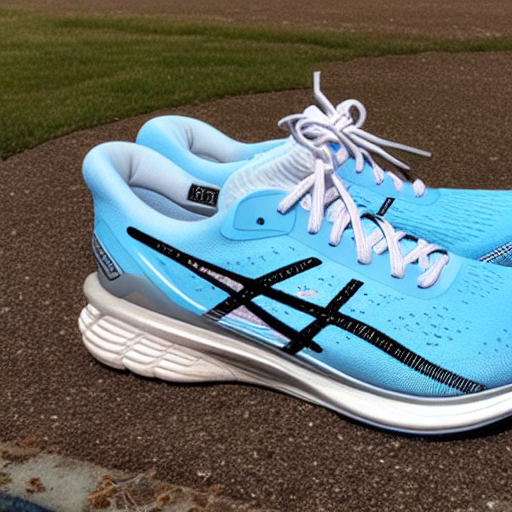

In [45]:
prompt = "A <zptx> sneaker"

num_samples = 1
num_rows = 1

all_images = []
for _ in range(num_rows):
    images = pipe_ti([prompt] * num_samples, num_inference_steps=30,
                  guidance_scale=6.5).images
    all_images.extend(images)

grid = image_grid(all_images, num_rows, num_samples)
grid

  0%|          | 0/30 [00:00<?, ?it/s]

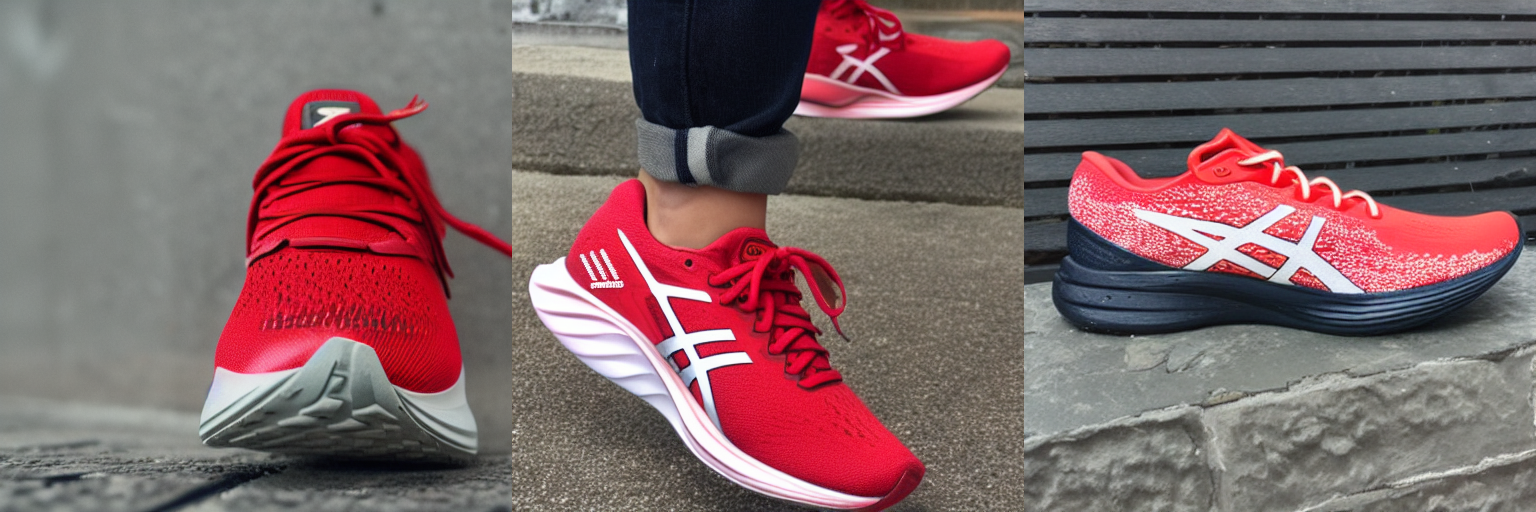

In [46]:
prompt = "A red and white <zptx> sneaker"

num_samples = 3
num_rows = 1

all_images = []
for _ in range(num_rows):
    images = pipe_ti([prompt] * num_samples, num_inference_steps=30,
                  guidance_scale=6.5).images
    all_images.extend(images)

grid = image_grid(all_images, num_rows, num_samples)
grid

### Inferencia desde Hugging Face

In [47]:
# Inferencia con Hugging Face:
from diffusers import StableDiffusionPipeline

pipe_ti = StableDiffusionPipeline.from_pretrained("sgonzalezygil/sd-finetuning-comparison-ti-v2")
pipe_ti.to("cuda")

model_index.json:   0%|          | 0.00/676 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/379 [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/560 [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/22.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/585 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.84k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/822 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/907 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.34.0.dev0",
  "_name_or_path": "sgonzalezygil/sd-finetuning-comparison-ti-v2",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

  0%|          | 0/40 [00:00<?, ?it/s]

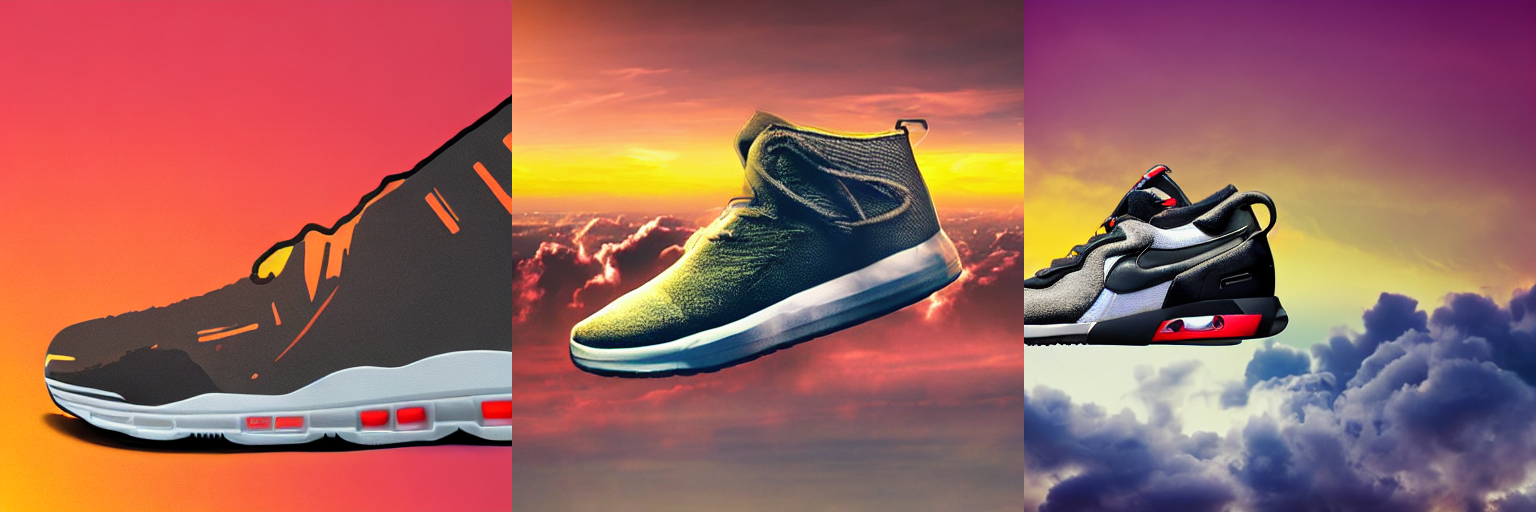

In [48]:
prompt = "A digital ad for a sneaker on a cloud. Urban, blurry background. High contrast, high detail, sunset lighting"

num_samples = 3
num_rows = 1

all_images = []
for _ in range(num_rows):
    images = pipe_ti([prompt] * num_samples, num_inference_steps=40,
                  guidance_scale=7.5).images
    all_images.extend(images)

grid = image_grid(all_images, num_rows, num_samples)
grid

  0%|          | 0/40 [00:00<?, ?it/s]

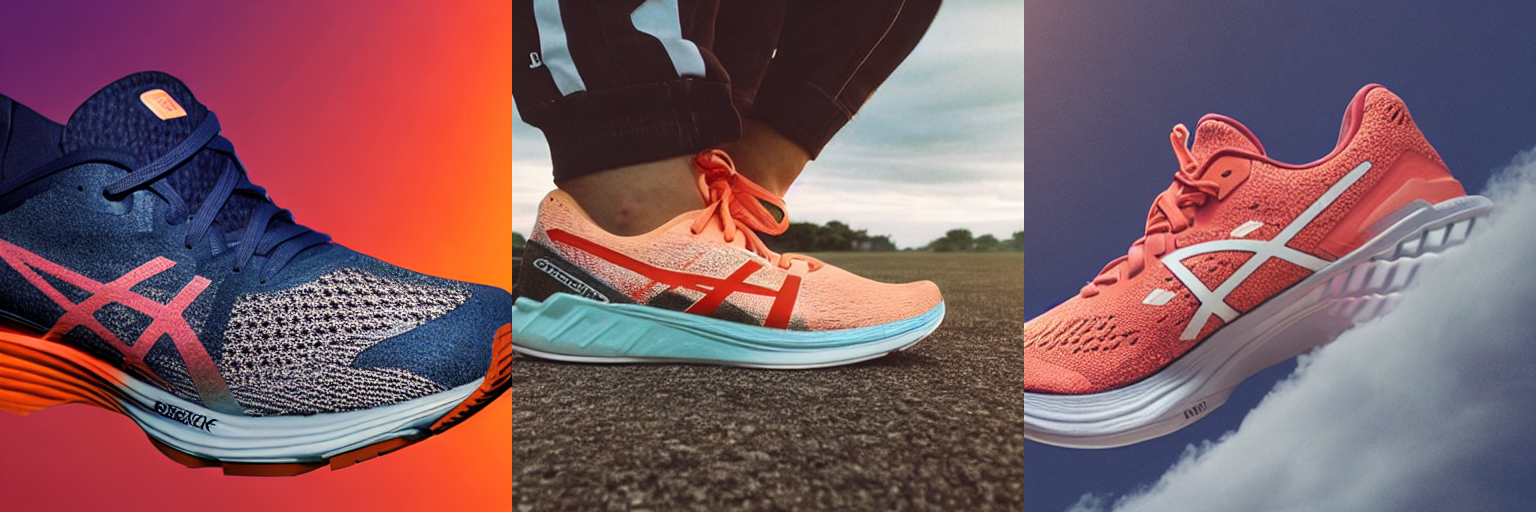

In [49]:
prompt = "A digital ad for a <zptx> sneaker on a cloud. Urban, blurry background. High contrast, high detail, sunset lighting"

num_samples = 3
num_rows = 1

all_images = []
for _ in range(num_rows):
    images = pipe_ti([prompt] * num_samples, num_inference_steps=40,
                  guidance_scale=6.5).images
    all_images.extend(images)

grid = image_grid(all_images, num_rows, num_samples)
grid

In [50]:
prompt = "A digital advertisement featuring the sneaker floating on a soft, realistic cloud. The sneaker is sharp, detailed, and well-lit with golden sunset lighting. Background is an urban cityscape, blurred to emphasize the shoe. High contrast, dramatic lighting, surreal but clean composition, modern ad style"

num_samples = 3
num_rows = 1

all_images = []
for _ in range(num_rows):
    images = pipe_ti([prompt] * num_samples, num_inference_steps=40,
                  guidance_scale=6.5).images
    all_images.extend(images)

grid = image_grid(all_images, num_rows, num_samples)
grid

Output hidden; open in https://colab.research.google.com to view.

  0%|          | 0/40 [00:00<?, ?it/s]

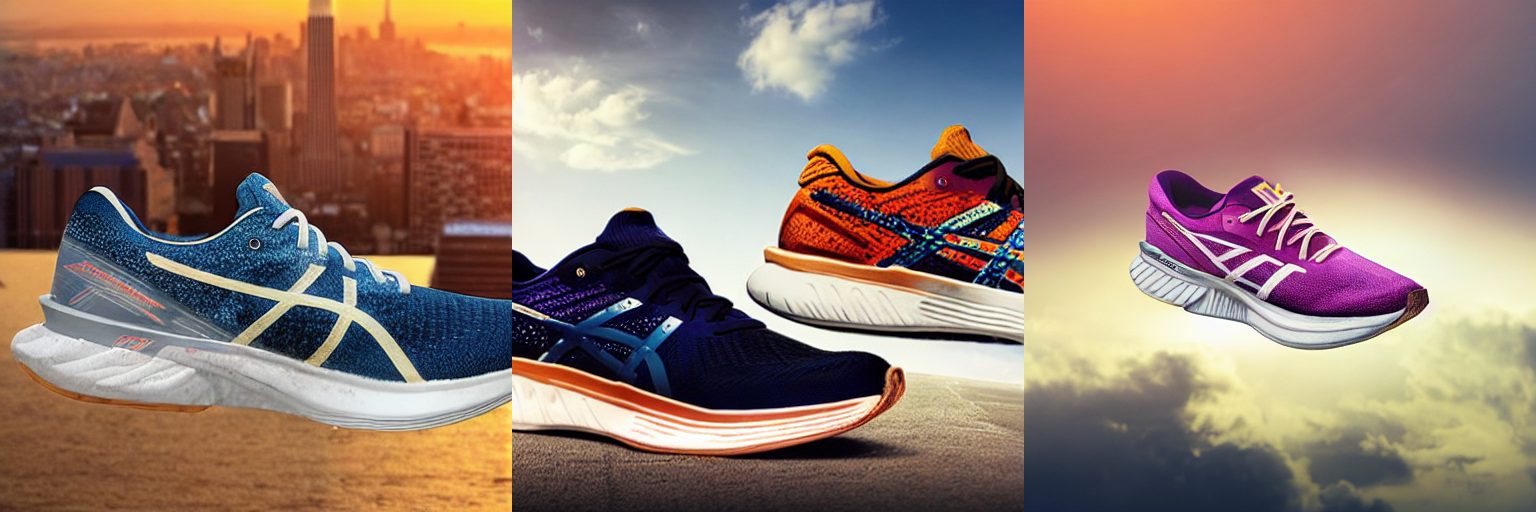

In [51]:
prompt = "A digital advertisement featuring the <zptx> sneaker floating on a soft, realistic cloud. The sneaker is sharp, detailed, and well-lit with golden sunset lighting. Background is an urban cityscape, blurred to emphasize the shoe. High contrast, dramatic lighting, surreal but clean composition, modern ad style"

num_samples = 3
num_rows = 1

all_images = []
for _ in range(num_rows):
    images = pipe_ti([prompt] * num_samples, num_inference_steps=40,
                  guidance_scale=6.5).images
    all_images.extend(images)

grid = image_grid(all_images, num_rows, num_samples)
grid